In [64]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

np.random.seed(0)

class Softmax():
    @staticmethod
    def compute(x):
        x = np.clip(x, 1e-15, 1 - 1e-15)
        e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return e_x / np.sum(e_x, axis=0, keepdims=True)
    
    def compute_derivative(self, x):
        value = self.compute(x)
        return value * (1 - value)
    
class ReLU():
    @staticmethod
    def compute(x):
        return np.maximum(x, 0)
    
    @staticmethod
    def compute_derivative(x):
        return x > 0
    
class LeakyReLU:
    @staticmethod
    def compute(x, alpha=0.01):
        return np.where(x >= 0, x, alpha * x)

    @staticmethod
    def compute_derivative(x, alpha=0.01):
        return np.where(x >= 0, 1, alpha)
    
class Sigmoid():
    @staticmethod
    def compute(x):
        x = np.clip( x, -500, 500 )
        return 1 / (1 + np.exp(-x))

    def compute_derivative(self, x):
        return x * (1 - x)
    
class CrossEntropy():
    @staticmethod
    def compute(y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return - (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()

    @staticmethod
    def compute_derivative(y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return - (y / y_pred) + (1 - y) / (1 - y_pred)
    
class MSE:
    @staticmethod
    def compute(y, y_pred):
        return ((y - y_pred) ** 2).mean()
    
    @staticmethod
    def compute_derivative(y, y_pred):
        return -2*(y - y_pred) / y.shape[0]
    
class RegressionError:
    @staticmethod
    def compute(y, y_pred):
        return (y - y_pred)
    
    @staticmethod
    def compute_derivative(y, y_pred):
        return (y - y_pred)
    

class Tanh:
    @staticmethod
    def compute(x):
        return np.tanh(x)

    @staticmethod
    def compute_derivative(x):
        return 1 - x ** 2
    
class Linear:
    @staticmethod
    def compute(x):
        return x

    @staticmethod
    def compute_derivative(x):
        return np.ones_like(x)

class NeuralNetworkStructure:
    def __init__(self, inputSize, outputSize, hiddenLayerSizes, hiddenLayerFunction, outputLayerFunction):
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.hiddenLayerSizes = hiddenLayerSizes
        self.layersSizes = hiddenLayerSizes + [outputSize]
        self.activationFunction = [hiddenLayerFunction] * len(hiddenLayerSizes) + [outputLayerFunction]
        self.layerInput = [None] * len(self.layersSizes)
        self.layerOutput = [None] * len(self.layersSizes)

        self.initializeWeights()

    def initializeWeights(self):
        self.weights = []
        self.bias = []
        
        previousLayerSize = self.inputSize
        for layerSize in self.layersSizes:
            weights = np.random.uniform(-np.sqrt(6 / (layerSize + previousLayerSize)), np.sqrt(6 / (layerSize + previousLayerSize)), size=(layerSize, previousLayerSize))
            self.weights.append(weights)
            self.bias.append(np.zeros((layerSize, 1)))
            previousLayerSize = layerSize
            

class NeuralNetwork:
    def __init__(self, neuralNetworkStructure, epochs, learningRate, lossFunction, batchSize = 1):
        self.structure = neuralNetworkStructure
        self.lossFunction = lossFunction
        self.learningRate = learningRate
        self.epochs = epochs
        self.batchSize = batchSize

    def Forward(self, X):
        previous_layer = np.reshape(X, (X.shape[0], 1))
        for id in range(len(self.structure.layersSizes)):
            self.structure.layerInput[id] = self.structure.weights[id].dot(previous_layer) + self.structure.bias[id]
            self.structure.layerOutput[id] = self.structure.activationFunction[id].compute(self.structure.layerInput[id])
            previous_layer = self.structure.layerOutput[id]
        return previous_layer
    
    
    def Backward(self, X, ExpectedY, PredictedY):
        previous_layer_error = self.lossFunction.compute_derivative(ExpectedY, PredictedY)
        
        for id in range(len(self.structure.layersSizes) -1, -1, -1):
            previous_layer_output = self.structure.layerOutput[id - 1] if id != 0 else X
            
            delta = previous_layer_error * self.structure.activationFunction[id].compute_derivative(self.structure.layerOutput[id])
            deltaW = np.dot(delta, previous_layer_output.T)
            deltaB = delta
            previous_layer_error = np.dot(self.structure.weights[id].T, delta)
                                        
            self.structure.weights[id] -= self.learningRate * deltaW
            self.structure.bias[id] -= self.learningRate * deltaB
    
    def Train(self, X, ExpectedY):
    
        X = np.reshape(X, (-1, 1))
        ExpectedY = np.reshape(ExpectedY, (-1, 1))
    
        predictedY = self.Forward(X)
        self.Backward(X, ExpectedY, predictedY)

    def Test(self, train_inputs, train_results, test_inputs, test_results):
        
        for epoch in range(self.epochs):
            random_range = list(range(len(train_inputs)))
            np.random.shuffle(random_range)
            
            for i in random_range:
            #for i in range(len(train_inputs)):
              self.Train(train_inputs[i], train_results[i])
            
            #if epoch % 10 == 0:        
            correct = 0
            for i in range(len(test_inputs)):
                predictedY = self.Forward(np.reshape(test_inputs[i], (-1, 1)))

                if np.argmax(predictedY) == np.argmax(test_results[i]):
                    correct += 1
            
            test_accuracy = correct / len(test_inputs)
            print(f"Epoch {epoch + 1}/{self.epochs}, Test Accuracy: {test_accuracy * 100:.2f}% Correct: {correct}, All: {len(test_inputs)} ")            
    
    def TestRegression(self, train_inputs, train_results, test_inputs):
        prediction = []
        for epoch in range(self.epochs):
            random_range = list(range(len(train_inputs)))
            np.random.shuffle(random_range)
            
            for i in random_range:
              self.Train(np.array(train_inputs[i]), np.array(train_results[i]))
            
            predictedYs = []
            for i in range(len(test_inputs)):
                predictedY = self.Forward(np.reshape(np.array(test_inputs[i]), (-1, 1)))
                predictedYs.append(predictedY)
                
            prediction = predictedYs
            
            
        return prediction   


In [3]:
def GetClassificationData(name):
    file = pd.read_csv(name, sep=",")

    input = np.array(file[["x", "y"]])
    results = np.array(file["cls"] - 1)

    num_classes = results.max() + 1
    results = np.eye(num_classes)[results]
    
    return input, results, num_classes

In [65]:
import numpy as np
import pandas as pd

train_vectors, train_results, num_classes = GetClassificationData("classification/data.simple.train.100.csv")
test_vectors, test_results, _ = GetClassificationData("classification/data.simple.test.100.csv")

nnS = NeuralNetworkStructure(
    inputSize = 2, 
    outputSize = 2, 
    hiddenLayerSizes = [8], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 100, 
    learningRate = 0.01,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy())

nn.Test(train_vectors, train_results, test_vectors, test_results)

Epoch 1/100, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 2/100, Test Accuracy: 57.00% Correct: 57, All: 100 
Epoch 3/100, Test Accuracy: 62.00% Correct: 62, All: 100 
Epoch 4/100, Test Accuracy: 84.00% Correct: 84, All: 100 
Epoch 5/100, Test Accuracy: 85.00% Correct: 85, All: 100 
Epoch 6/100, Test Accuracy: 84.00% Correct: 84, All: 100 
Epoch 7/100, Test Accuracy: 84.00% Correct: 84, All: 100 
Epoch 8/100, Test Accuracy: 86.00% Correct: 86, All: 100 
Epoch 9/100, Test Accuracy: 86.00% Correct: 86, All: 100 
Epoch 10/100, Test Accuracy: 87.00% Correct: 87, All: 100 
Epoch 11/100, Test Accuracy: 91.00% Correct: 91, All: 100 
Epoch 12/100, Test Accuracy: 90.00% Correct: 90, All: 100 
Epoch 13/100, Test Accuracy: 90.00% Correct: 90, All: 100 
Epoch 14/100, Test Accuracy: 90.00% Correct: 90, All: 100 
Epoch 15/100, Test Accuracy: 90.00% Correct: 90, All: 100 
Epoch 16/100, Test Accuracy: 90.00% Correct: 90, All: 100 
Epoch 17/100, Test Accuracy: 90.00% Correct: 90, All: 100 
Epoch 

In [66]:
import numpy as np
import pandas as pd

train_vectors, train_results, num_classes = GetClassificationData("classification/data.simple.train.10000.csv")
test_vectors, test_results, _ = GetClassificationData("classification/data.simple.test.10000.csv")

nnS = NeuralNetworkStructure(
    inputSize = 2, 
    outputSize = 2, 
    hiddenLayerSizes = [8], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 100, 
    learningRate = 0.1,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy())

nn.Test(train_vectors, train_results, test_vectors, test_results)

Epoch 1/100, Test Accuracy: 92.14% Correct: 9214, All: 10000 
Epoch 2/100, Test Accuracy: 98.20% Correct: 9820, All: 10000 
Epoch 3/100, Test Accuracy: 98.57% Correct: 9857, All: 10000 


KeyboardInterrupt: 

In [70]:
import numpy as np
import pandas as pd

train_vectors, train_results, num_classes = GetClassificationData("classification/data.three_gauss.train.10000.csv")
test_vectors, test_results, _ = GetClassificationData("classification/data.three_gauss.test.10000.csv")

nnS = NeuralNetworkStructure(
    inputSize = 2, 
    outputSize = num_classes, 
    hiddenLayerSizes = [8, 8], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 100, 
    learningRate = 0.01,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy(),
    batchSize=10)

nn.Test(train_vectors, train_results, test_vectors, test_results)

Epoch 1/100, Test Accuracy: 91.05% Correct: 27314, All: 30000 
Epoch 2/100, Test Accuracy: 93.10% Correct: 27931, All: 30000 
Epoch 3/100, Test Accuracy: 90.53% Correct: 27160, All: 30000 
Epoch 4/100, Test Accuracy: 93.38% Correct: 28014, All: 30000 
Epoch 5/100, Test Accuracy: 92.40% Correct: 27721, All: 30000 


KeyboardInterrupt: 

In [15]:
def convert_range(data, range_min, range_max):
    old_min = data.min()
    old_max = data.max()
    return (((data - old_min) * (range_max - range_min)) / (old_max - old_min)) + range_min

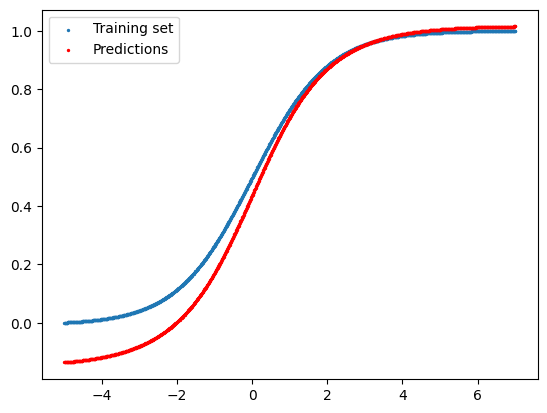

In [16]:
import numpy as np
import pandas as pd

test = pd.read_csv("regression/data.activation.test.500.csv", sep=",")
train = pd.read_csv("regression/data.activation.train.500.csv", sep=",")

train_vectors = np.array(train["x"])
train_results = convert_range(np.array(train["y"]), 0, 1)
test_vectors = np.array(test["x"])
test_results = convert_range(np.array(test["y"]), 0, 1)

nnS = NeuralNetworkStructure(
    inputSize = 1, 
    outputSize = 1, 
    hiddenLayerSizes = [3, 2, 2], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Linear())

nn = NeuralNetwork(  
    epochs = 800, 
    learningRate = 0.1,
    neuralNetworkStructure = nnS,
    lossFunction = MSE())

predictedPoints = nn.TestRegression(train_vectors, train_results, test_vectors)

import matplotlib.pyplot as plt

plt.scatter(test_vectors, test_results, label='Training set', s=2)
plt.scatter(test_vectors, predictedPoints, color='r', label='Predictions', s=2)
plt.legend()
plt.show()


In [72]:
import numpy as np
from mnist.loader import MNIST

# Load the MNIST dataset
mndata = MNIST("mnist")  # Replace with the path to your MNIST data
mndata.gz = True

# Load the training and testing data
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

# Convert to NumPy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10
train_labels = np.eye(num_classes)[train_labels]
test_labels = np.eye(num_classes)[test_labels]

nnS = NeuralNetworkStructure(
    inputSize = 784, 
    outputSize = 10, 
    hiddenLayerSizes = [28], 
    hiddenLayerFunction = Tanh(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 1000, 
    learningRate = 0.1,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy()
)

nn.Test(train_images, train_labels, test_images, test_labels)

Epoch 1/1000, Test Accuracy: 31.18% Correct: 3118, All: 10000 
Epoch 2/1000, Test Accuracy: 30.53% Correct: 3053, All: 10000 


KeyboardInterrupt: 